# Modeling Frequency Dynamics in Power Grids with the Swing Equation

This notebook introduces the application of the Swing Equation to capture the frequency dynamics in power grids. The implementation utilizes a Stochastic Differential Equation (SDE) as an abstract base, allowing for more precise formulations. To approximate the solutions of these equations, we employ the Euler-Maruyama method tailored for SDEs.

In addition to the abstract base class, we provide an implementation for the aggregated swing equation, incorporating both linear and nonlinear control terms for a more comprehensive representation.

The primary code segment has been converted into a `.py` format, facilitating its use in other notebooks for experimental purposes across diverse interests. The code can be accessed [here](add_link_here).

In [1]:
# Add the 'src' as root folder, to find other modules in the project
import sys
sys.path.append("../../")

# Import external modules 
import torch
import numpy as np

# Import internal modules
from utilities.analysis.frequency_analysis import FrequencyAnalysis

## Solving Stochastic Differential Equations with the Euler-Maruyama Method

Stochastic Differential Equations (SDEs) describe systems subjected to random fluctuations. One numerical method for solving SDEs is the Euler-Maruyama method. It approximates the solution by discrete points using the formula:

$$
dX(t) = a(t, X(t)) dt + b(t, X(t)) dW(t)
$$

Here, $W(t)$ is a Wiener process. The Euler-Maruyama method updates the solution from $X_n$ to $X_{n+1}$ with a step size $\tau$:

$$
X_{n+1} = X_n + \tau a(t_n, X_n) + b(t_n, X_n) \Delta W_n
$$

where $\Delta W_n = W(t_{n+1}) - W(t_n)$ is a normally distributed random vector with expectation $0$ and variance $\tau$.

In [2]:
class SDE(object):
    """
    This class implements the Euler-Maruyama method for solving stochastic differential equations (SDEs).
    """

    def __init__(self, dt=1, T=900, X0=[0.0, 0.0]):
        """
        Initializes the SDE class.

        Parameters:
        dt: Time step
        T: End time
        X0: Initial value
        """
        self.dt = dt
        self.T = T
        self.X0 = X0

    def _a(self, X, t, parameters):
        raise NotImplementedError("Subclass must implement simulate method.")
    
    def _b(self, X, t, parameters):
        raise NotImplementedError("Subclass must implement simulate method.")

    def _solve(self, a, b, parameters):
        """
        Solves the SDE using the Euler-Maruyama method.

        Parameters:
        a: Function for the deterministic part of the SDE
        b: Function for the stochastic part of the SDE

        Returns:
        X: Approximate solution of the SDE
        t: Time grid
        """
        N = int(self.T / self.dt) # Number of time steps
        d = len(self.X0) # Dimension of the system
        X = np.zeros((d, N)) # Initialization of the solution
        X[:, 0] = self.X0 # Setting the initial value
        t = np.linspace(0, self.T, N) # Time grid
        W = np.zeros((d, N)) # Initialization of the Wiener process

        for i in range(N-1):

            # Random fluctuation, corresponds to \sqrt{dt} * Z, where Z ~ N(0,1), so Z ~ N(0,dt)
            dW = np.sqrt(self.dt) * np.random.normal(size=d) # Wiener process increment

            # Euler-Maruyama step, corresponds to X_{i+1} = X_i + a(X_i, t_i) * dt + b(X_i, t_i) * dW
            X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW 

        return X, t
    
    def simulator(self, parameters):
        raise NotImplementedError("Subclass must implement simulate method.")

## Applying Euler-Maruyama to the linear Swing Equation

Let's apply the Euler-Maruyama method to the linear Swing Equation, which describes the dynamics of phase angles $\theta$ and frequency deviations $\omega$ of a generator in a power grid:

$$
\frac{d\omega}{dt} = c_1 \omega + c_2 \theta + P_0 + t P_1 + \epsilon \xi
$$

$$
\frac{d\theta}{dt} = \omega
$$

Splitting them into the stochastic and deterministic parts of the generalized SDE results in:

$$
a(t, X(t)) = (c_1 \omega + c_2 \theta + P_0 + t P_1, \omega)^T
$$

$$
b(t, X(t)) = (\epsilon, 0)^T
$$

Here, $c_1, c_2, P_0, P_1, \epsilon$ are constants, and $\xi$ is a noise source. When $\xi$ is modeled as a Wiener process, we have an SDE suitable for the Euler-Maruyama method. The Euler-Maruyama method approximates the solution of the SDE at discrete time steps. The update equations are:

$$
\omega_{n+1} = \omega_n + \tau (c_1 \omega_n + c_2 \theta_n + P_0 + t_n P_1) + \epsilon \Delta W_n
$$

$$
\theta_{n+1} = \theta_n + \tau \omega_n
$$

where $\tau$ is the time step size, $t_n$ is the current time, and $\Delta W_n$ is a random increment that follows a normal distribution with mean 0 and variance $\tau$. The constants $c_1$ and $c_2$ represent primary and secondary control coefficients, while $P_0$ and $P_1$ are associated with system parameters. The term $\epsilon$ accounts for the noise strength in the system.

In [3]:
class LinearSwing(SDE):
    """
    This class implements the Euler-Maruyama method for solving the given system of linear stochastic differential equations (SDEs).
    """

    def __init__(self, dt=1, T=900, base_frequency=50, X0=[0.0, 0.0]):
        """
        Initializes the LinearSwing class.

        Parameters:
        dt: Time step
        T: End time
        X0: Initial value
        """
        super().__init__(dt, T, X0)
        self.base_frequency = base_frequency

    def _a(self, X, t, parameters):
        """
        Function for the deterministic part of the SDE.
        The deterministic part of the SDE is given by the formula:
        dω/dt = c1 * ω + c2 * θ + P0 + t * P1
        dθ/dt = ω
        """
        c1, c2, P0, P1, epsilon = parameters
        omega, theta = X
        return np.array([c1 * omega + c2 * theta + P0 + t * P1, omega])

    def _b(self, X, t, parameters):
        """
        Function for the stochastic part of the SDE.
        The stochastic part of the SDE is given by the formula:
        dω/dt = ε
        dθ/dt = 0
        """
        c1, c2, P0, P1, epsilon = parameters
        return np.array([epsilon, 0])

    def simulator(self, parameters):
        """
        Simulates the SDE using the Euler-Maruyama method.

        Parameters:
        parameters: Parameters of the SDE

        Returns:
        X: Approximate solution of the SDE
        t: Time grid
        """
        # The _solve method is called with the deterministic and stochastic parts of the SDE (_a and _b methods)
        # and the parameters of the SDE. It returns the approximate solution of the SDE and the time grid.
        (omega, theta), t = self._solve(lambda X, t: self._a(X, t, parameters), lambda X, t: self._b(X, t, parameters), parameters)
        
        # The simulator method returns the frequency deviations omega shifted by the base frequency.
        return torch.from_numpy(omega + self.base_frequency)


## Handling Nonlinearities

In cases where $c_1$ and $c_2$ are nonlinear functions, adjustments are needed.

$$
\frac{d\omega}{dt} = c_1(\omega) + c_2(\theta) + P_0 + t P_1 + \epsilon \xi
$$

$$
\frac{d\theta}{dt} = \omega
$$

After splitting the formulation into the deterministic and stochastic parts of the generic SDE, we obtain:

$$
a(t, X(t)) = (c_1(\omega) + c_2(\theta) + P_0 + t P_1, \omega)^T
$$

$$
b(t, X(t)) = (\epsilon, 0)^T
$$

The corresponding Euler-Maruyama method becomes:

$$
\omega_{n+1} = \omega_n + \tau (c_1(\omega_n) + c_2(\theta_n) + P_0 + t_n P_1) + \epsilon \Delta W_n
$$

$$
\theta_{n+1} = \theta_n + \tau \omega_n
$$

This flexible approach enables the application of the Euler-Maruyama method to a wide range of formulations of the Swing Equation, accommodating both linear and nonlinear dynamics.

In [4]:
class Swing(SDE):
    """
    This class implements the Euler-Maruyama method for solving the given system of nonlinear or linear stochastic differential equations (SDEs).
    """

    def __init__(self, dt=1, T=900, base_frequency=50, X0=[0.0, 0.0], f=lambda x, y: -x * y, g=lambda x, y: -x * y):
        """
        Initializes the Swing class.

        Parameters:
        dt: Time step
        T: End time
        X0: Initial value
        f: Nonlinear function for the deterministic part of the SDE
        g: Nonlinear function for the deterministic part of the SDE
        """
        super().__init__(dt, T, X0)
        self.f = f
        self.g = g
        self.base_frequency = base_frequency

    def _a(self, X, t, parameters):
        """
        Function for the deterministic part of the SDE.
        The deterministic part of the SDE is given by the formula:
        dω/dt = f(c1, ω) + g(c2, θ) + P0 + t * P1
        dθ/dt = ω
        where f(c1, ω) is a nonlinear function of ω and c1, and g(c2, θ) respectively.
        """
        c1, c2, P0, P1, epsilon = parameters
        omega, theta = X
        return np.array([self.f(c1, omega) + self.g(c2, theta) + P0 + t * P1, omega])

    def _b(self, X, t, parameters):
        """
        Function for the stochastic part of the SDE.
        The stochastic part of the SDE is given by the formula:
        dω/dt = ε
        dθ/dt = 0
        """
        c1, c2, P0, P1, epsilon = parameters
        return np.array([epsilon, 0])

    def simulator(self, parameters):
        """
        Simulates the SDE using the Euler-Maruyama method.

        Parameters:
        parameters: Parameters of the SDE

        Returns:
        X: Approximate solution of the SDE
        t: Time grid
        """
        # The _solve method is called with the deterministic and stochastic parts of the SDE (_a and _b methods)
        # and the parameters of the SDE. It returns the approximate solution of the SDE and the time grid.
        (omega, theta), t = self._solve(lambda X, t: self._a(X, t, parameters), lambda X, t: self._b(X, t, parameters), parameters)
        
        # The simulator method returns the frequency deviations omega shifted by the base frequency.
        return torch.from_numpy(omega + self.base_frequency)


## Examples

In [53]:
# Define parameter values for swing
c1 = 0.01
c2 = 0.0001
P0 = 0.001
P1 = 0.00001
epsilon = 0.001

# Construct parameter bundle for swing
parameters = torch.tensor([c1, c2, P0, P1, epsilon])

analyzer = FrequencyAnalysis(dt=1, T=900)

### Linear Control ($c_1$, $c_2$)

To model $c_1$ and $c_2$ as linear coefficents we use the ``GeneralSwing`` and assume ``f`` to be a functional term, expressing $\lambda$ x y. -x*y and ``g`` respectively. To make this happen we need to define neither ``f`` nor ``g``, since they are already implemented as linear functions by default.

<module 'matplotlib.pyplot' from '/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/.venv/lib64/python3.9/site-packages/matplotlib/pyplot.py'>

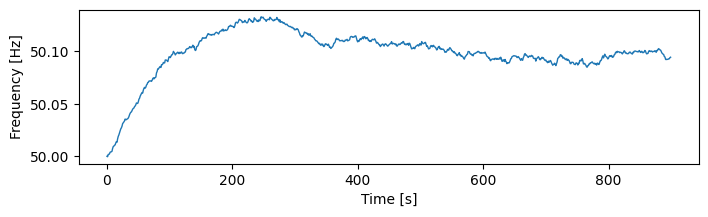

In [54]:
# Use only default simulator-parameters
swing = Swing()

# Compute simulation given the parameters previously defined
simulation = swing.simulator(parameters)

analyzer.plot_frequency_analytics(simulation)

### Nonlinear Control ($c_1$, $c_2$)

To model $c_1$ and $c_2$ as non-linear functions we use the ``GeneralSwing`` and define ``f`` as a functional term of our choice and ``g`` respectively.

As a precise follow up and experminent to determine the influence of terms in out formulation, we introduce some choices of nonlinear terms and visualize them to provide a comprehensive view on the nonlinear influence to the swing equation.

<module 'matplotlib.pyplot' from '/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/.venv/lib64/python3.9/site-packages/matplotlib/pyplot.py'>

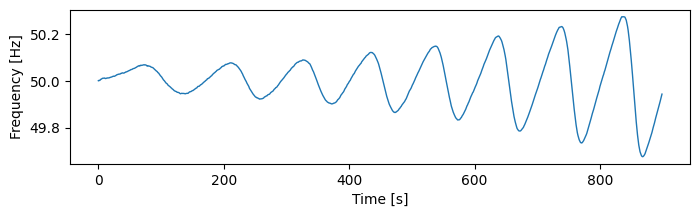

In [55]:
# Use mostly default simulator-parameters, but change the linearity of the statevariables
swing = Swing(f=lambda x, y: -x*y**3, g=lambda x, y: -x*y**3)

# Compute simulation given the parameters previously defined
simulation = swing.simulator(parameters)

# Plot the computed simulation
analyzer.plot_frequency_analytics(simulation)